In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import time


In [ ]:
from rxrmask.core import Atom, Structure, FormFactorLocalDB, ParametersContainer
from rxrmask.core import create_compound
from rxrmask.utils import plot_reflectivity, plot_energy_scan, plot_density_profile, get_density_profile_from_element_data
from rxrmask.backends import reflectivity_pr, reflectivity_parallel_pr, energy_scan_pr, energy_scan_parallel_pr

In [6]:
mn_ff = FormFactorLocalDB(element="Mn", is_magnetic=False)
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
c_ff = FormFactorLocalDB(element="C", is_magnetic=False)
la_ff = FormFactorLocalDB(element="La", is_magnetic=False)

la_atom = Atom(
    Z=57,
    name="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    ff=c_ff,
)

In [7]:
parameters_container = ParametersContainer()

comp_SrTiO3 = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=0.0,
)
comp_LaMnO3 = create_compound(
    parameters_container=parameters_container,
    name="LaMnO3",
    formula="La:1,Mn:1,O:3",
    thickness=10.0,
    density=6.52,
    atoms=[la_atom, mn_atom, o_atom],
    roughness=0,
)
comp_CCO = create_compound(
    parameters_container=parameters_container,
    name="CCO",
    formula="C:2,O:1",
    thickness=10.0,
    density=5.0,
    atoms=[c_atom, o_atom],
    roughness=0,
)

struc = Structure(name=f"Test Structure", n_compounds=2, params_container=parameters_container)
struc.add_compound(0, comp_SrTiO3)
struc.add_compound(1, comp_LaMnO3)
# struc.add_compound(2, comp_CCO)
struc.create_layers(step=0.1)

In [8]:
def print_compound_info(compound):
    print(f"---- Compound: {compound.name}")
    print(f"Formula: {compound.formula}")
    print(f"Thickness: {compound.thickness} nm")
    print(f"Density: {compound.density} g/cm³")
    print("CompoundDetails:")
    for detail in compound.compound_details:
        print(f"  {detail.name}: {detail.stochiometric_fraction} {detail.thickness.get()} {detail.molar_density.get()}")

print_compound_info(comp_SrTiO3)
print_compound_info(comp_LaMnO3)

---- Compound: SrTiO3
Formula: Sr:1,Ti:1,O:3
Thickness: Parameter(value=50.0, id=12, name='SrTiO3-thickness', min_value=None, max_value=None, fit=False) nm
Density: Parameter(value=5.12, id=13, name='SrTiO3-density', min_value=None, max_value=None, fit=False) g/cm³
CompoundDetails:
  Sr: 1 50.0 0.027899140248760067
  Ti: 1 50.0 0.027899140248760067
  O: 3 50.0 0.0836974207462802
---- Compound: LaMnO3
Formula: La:1,Mn:1,O:3
Thickness: Parameter(value=10.0, id=28, name='LaMnO3-thickness', min_value=None, max_value=None, fit=False) nm
Density: Parameter(value=6.52, id=29, name='LaMnO3-density', min_value=None, max_value=None, fit=False) g/cm³
CompoundDetails:
  La: 1 10.0 0.026959784024012397
  Mn: 1 10.0 0.026959784024012397
  O: 3 10.0 0.0808793520720372


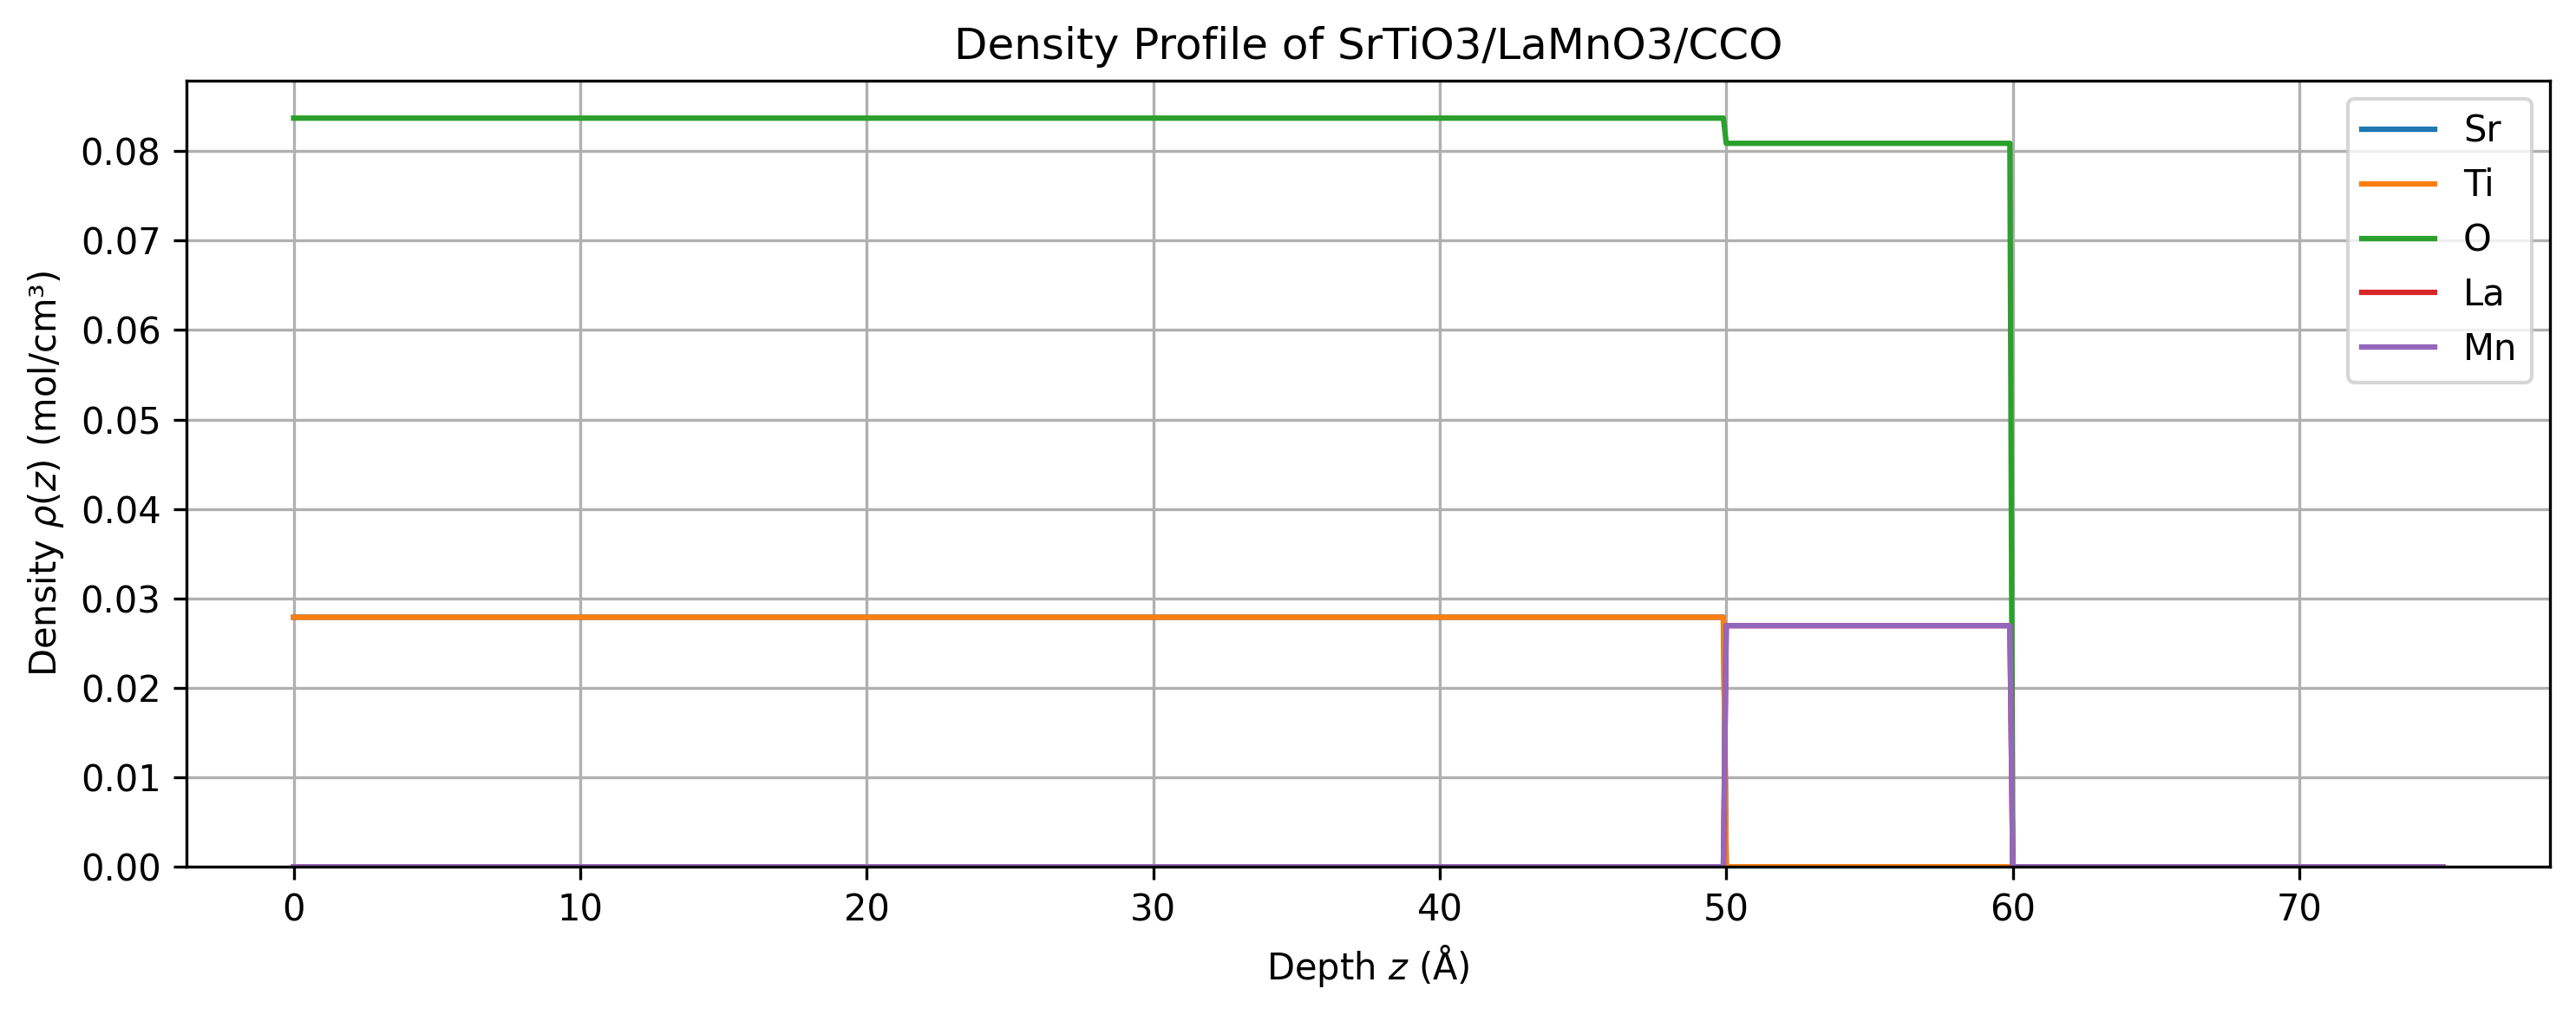

In [ ]:
z, dens, m_dens, _ = get_density_profile_from_element_data(
    struc.element_data, struc.atoms, struc.step
)
plot_density_profile(z, dens, title="Density Profile of SrTiO3/LaMnO3/CCO")

Tiempo de ejecución: 0.017 segundos


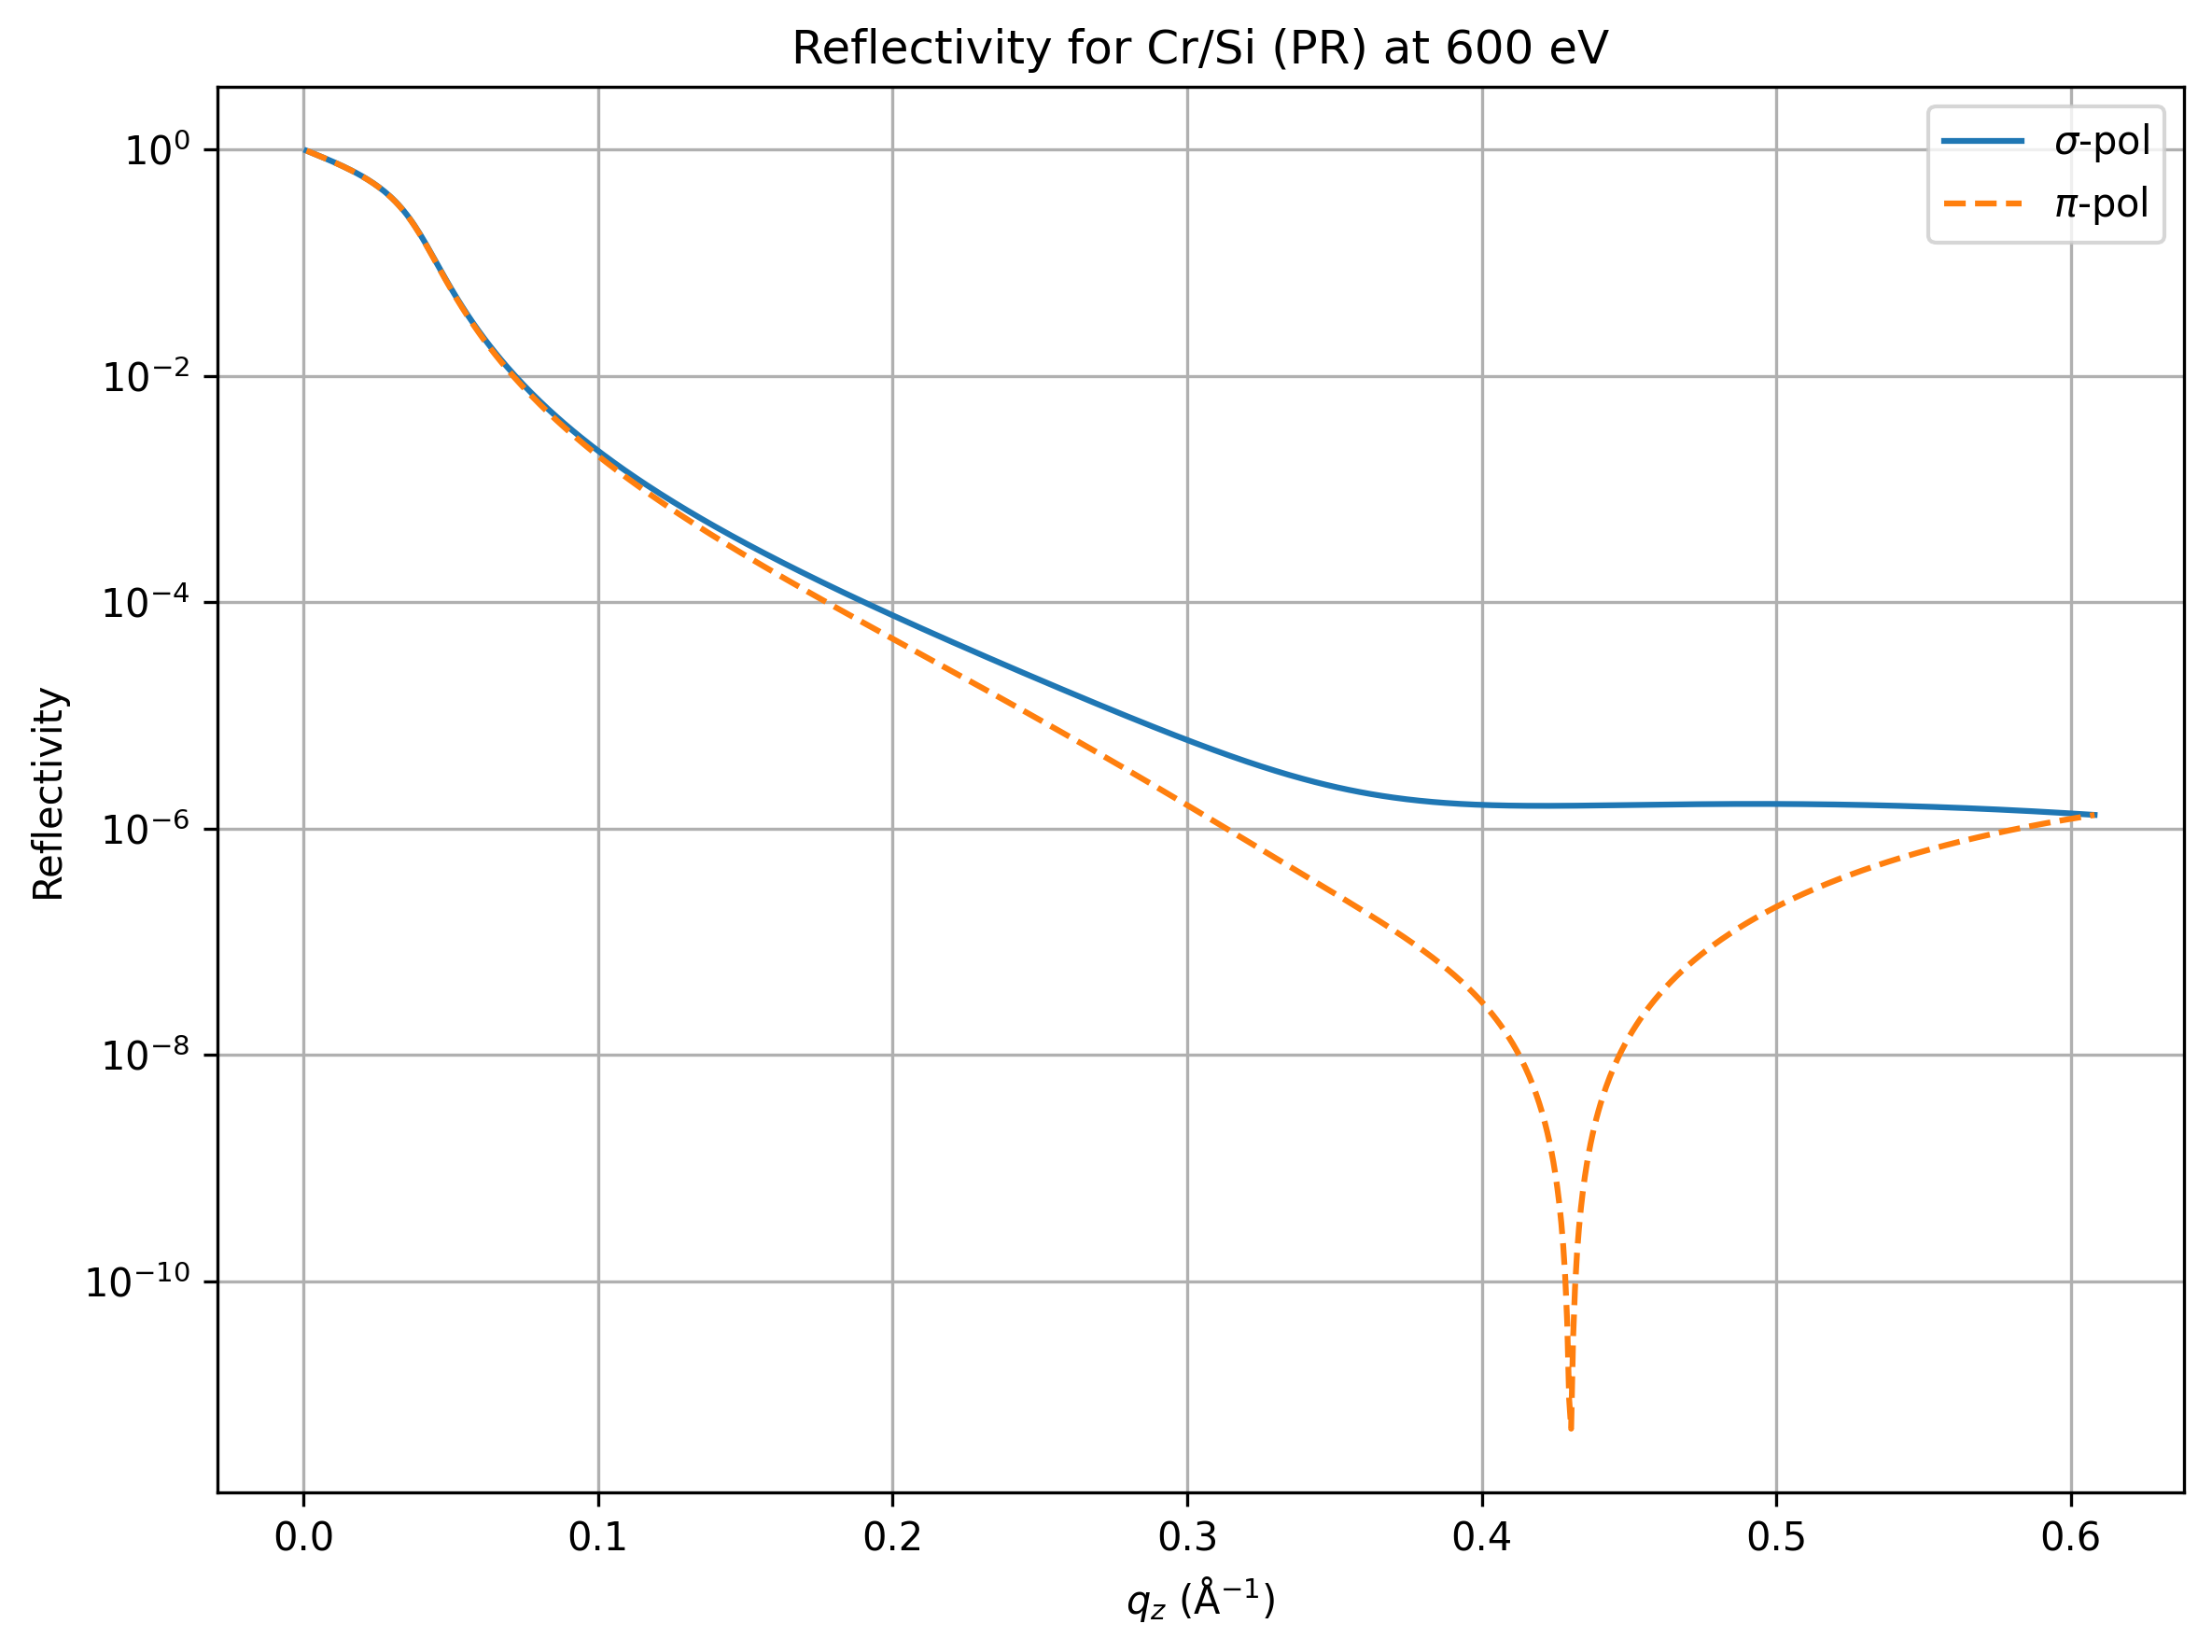

In [11]:

start_time = time.time()

E_eV = 600
Theta = np.linspace(0.1, 89.1, num=1001)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

qz_pr, R_phi_pr, R_pi_pr  = reflectivity_pr(struc, qz, E_eV, als=True)
end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time:.3f} segundos")

plot_reflectivity(qz_pr, R_phi_pr, R_pi_pr, E_eV, "Cr/Si (PR)")

Tiempo de ejecución: 0.044 segundos


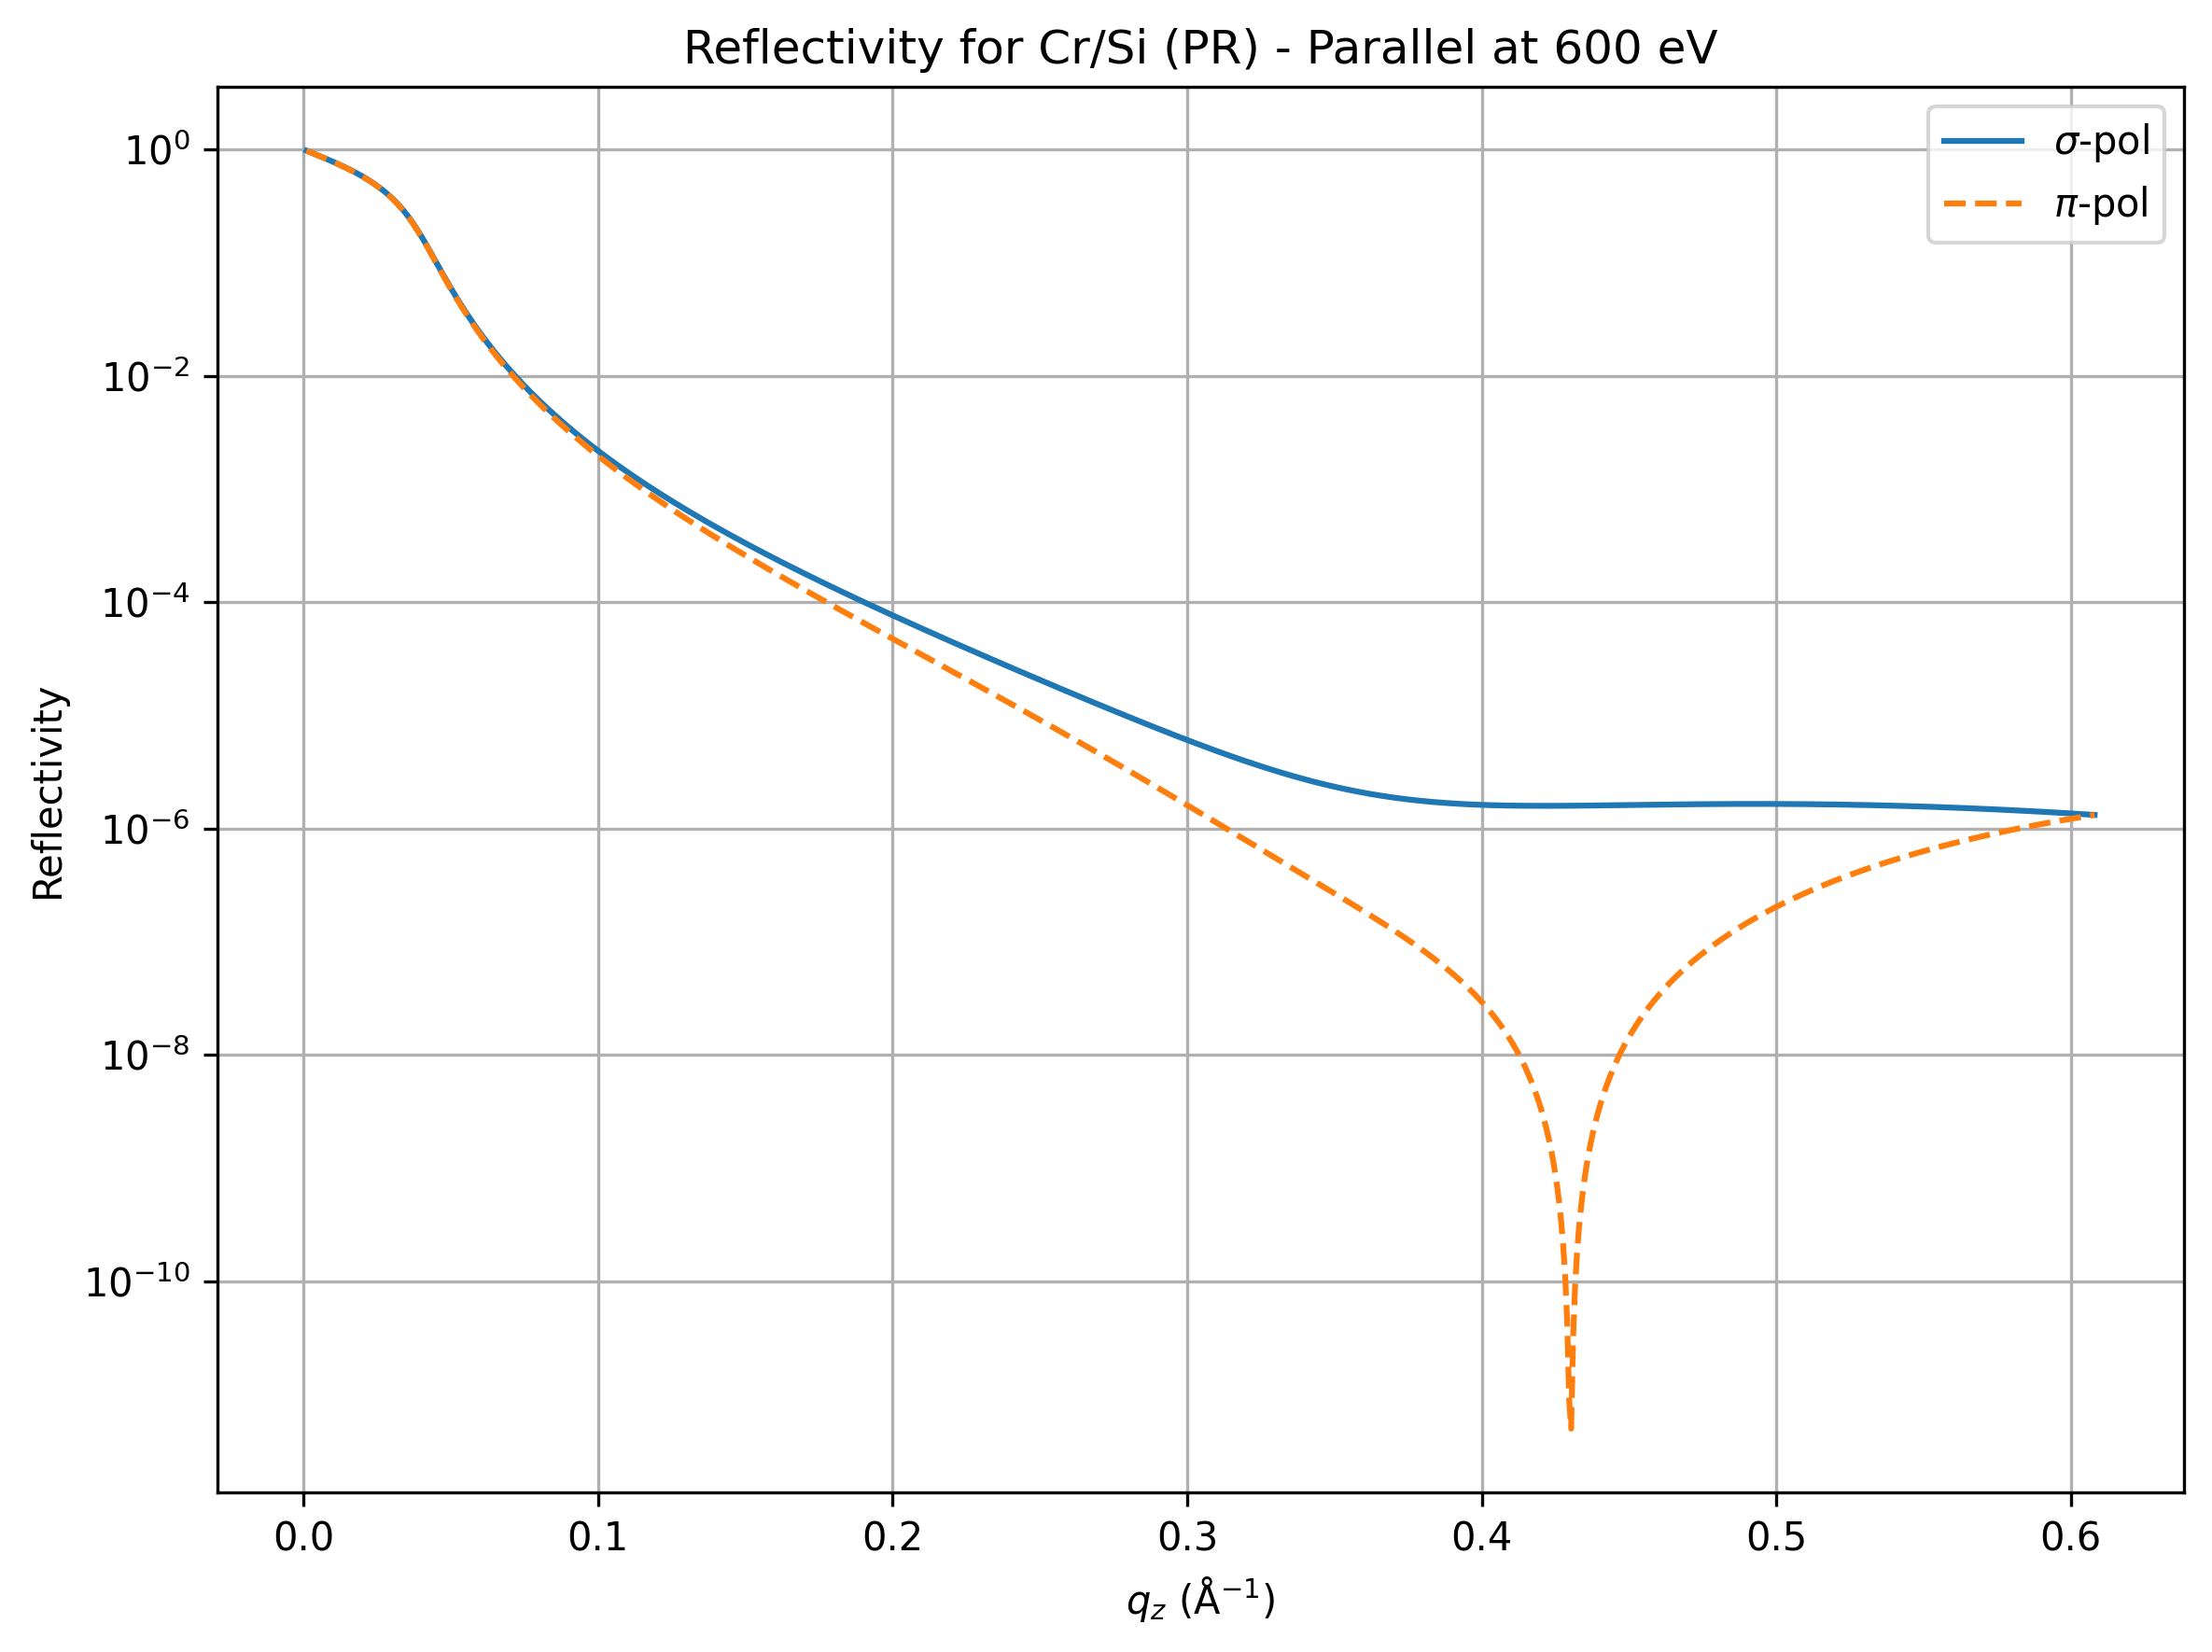

In [17]:
start_time = time.time()

E_eV = 600
Theta = np.linspace(0.1, 89.1, num=1001)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

qz_pr, R_phi_pr, R_pi_pr  = reflectivity_parallel_pr(struc, qz, E_eV, precision=1e-6, n_jobs=-1, use_threads=True)

end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time:.3f} segundos")

plot_reflectivity(qz_pr, R_phi_pr, R_pi_pr, E_eV, "Cr/Si (PR) - Parallel")

Tiempo de ejecución: 0.182 segundos


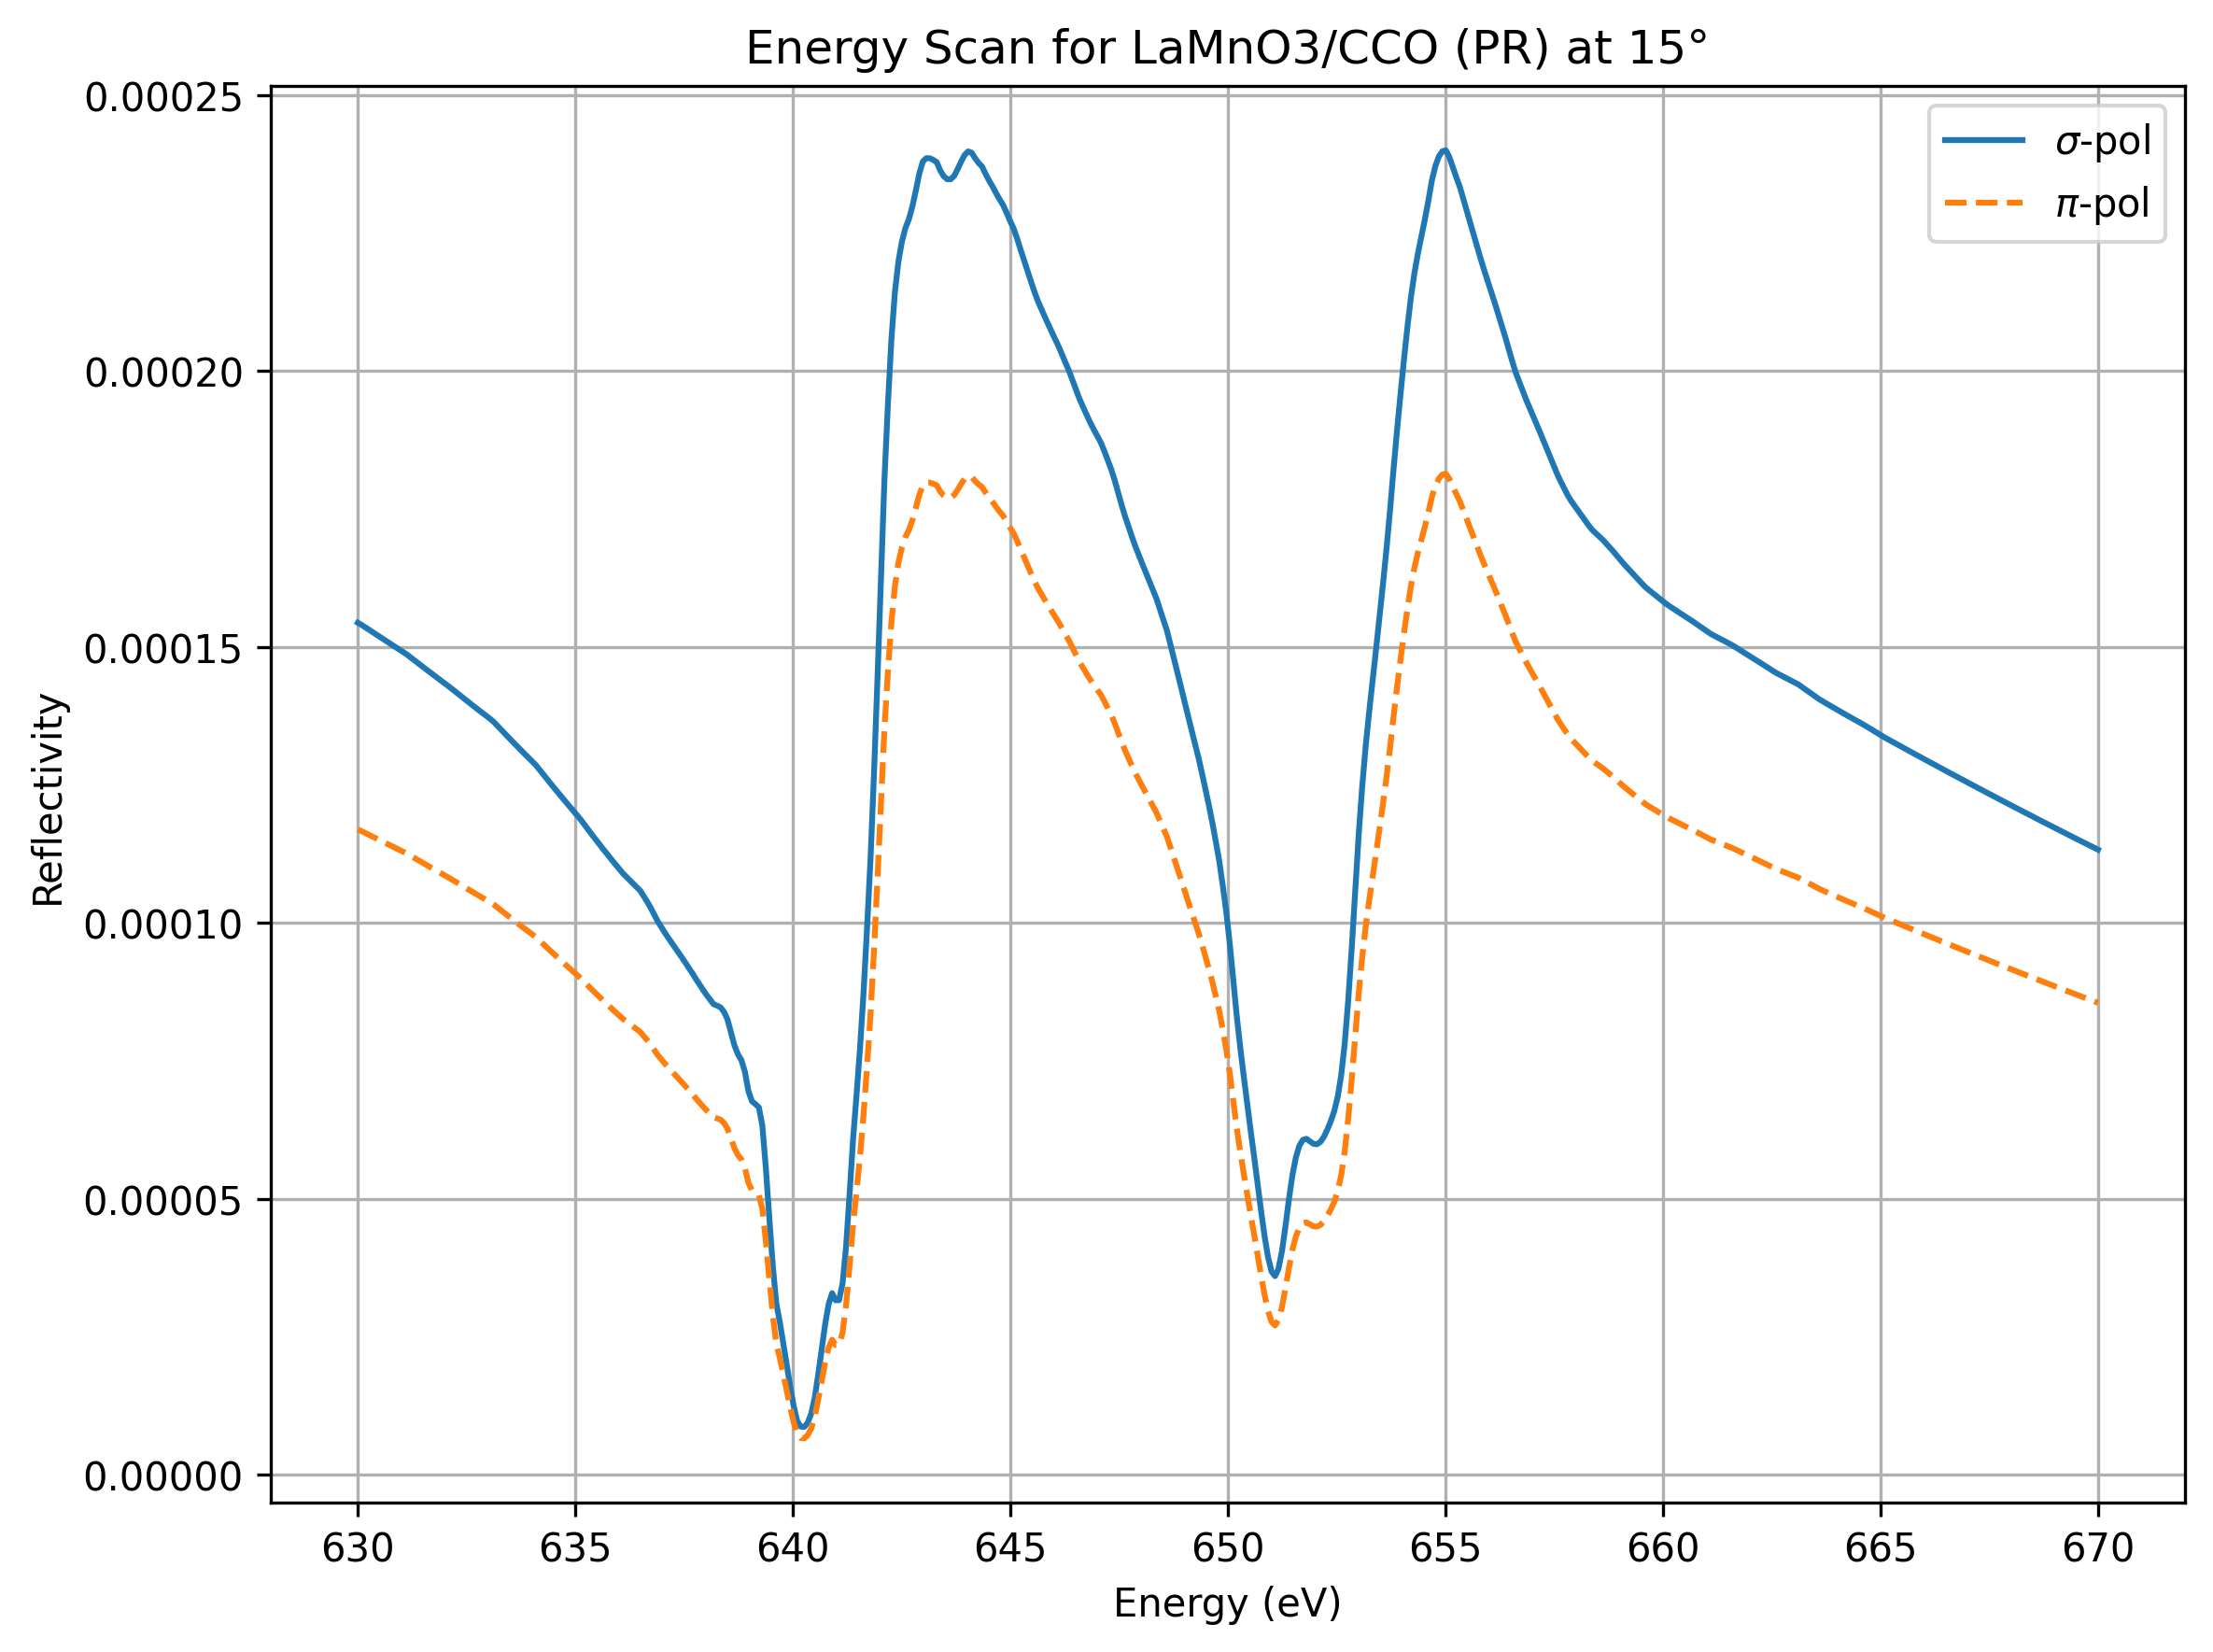

In [79]:
start_time = time.time()

e_evs = np.linspace(630, 670, num=500).tolist()
theta_deg = 15

e_pr, R_phi_pr, R_pi_pr  = energy_scan_pr(struc, e_evs, theta_deg)

end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time:.3f} segundos")

plot_energy_scan(e_pr, R_phi_pr, R_pi_pr, theta_deg, "LaMnO3/CCO (PR)")

Tiempo de ejecución: 0.193 segundos


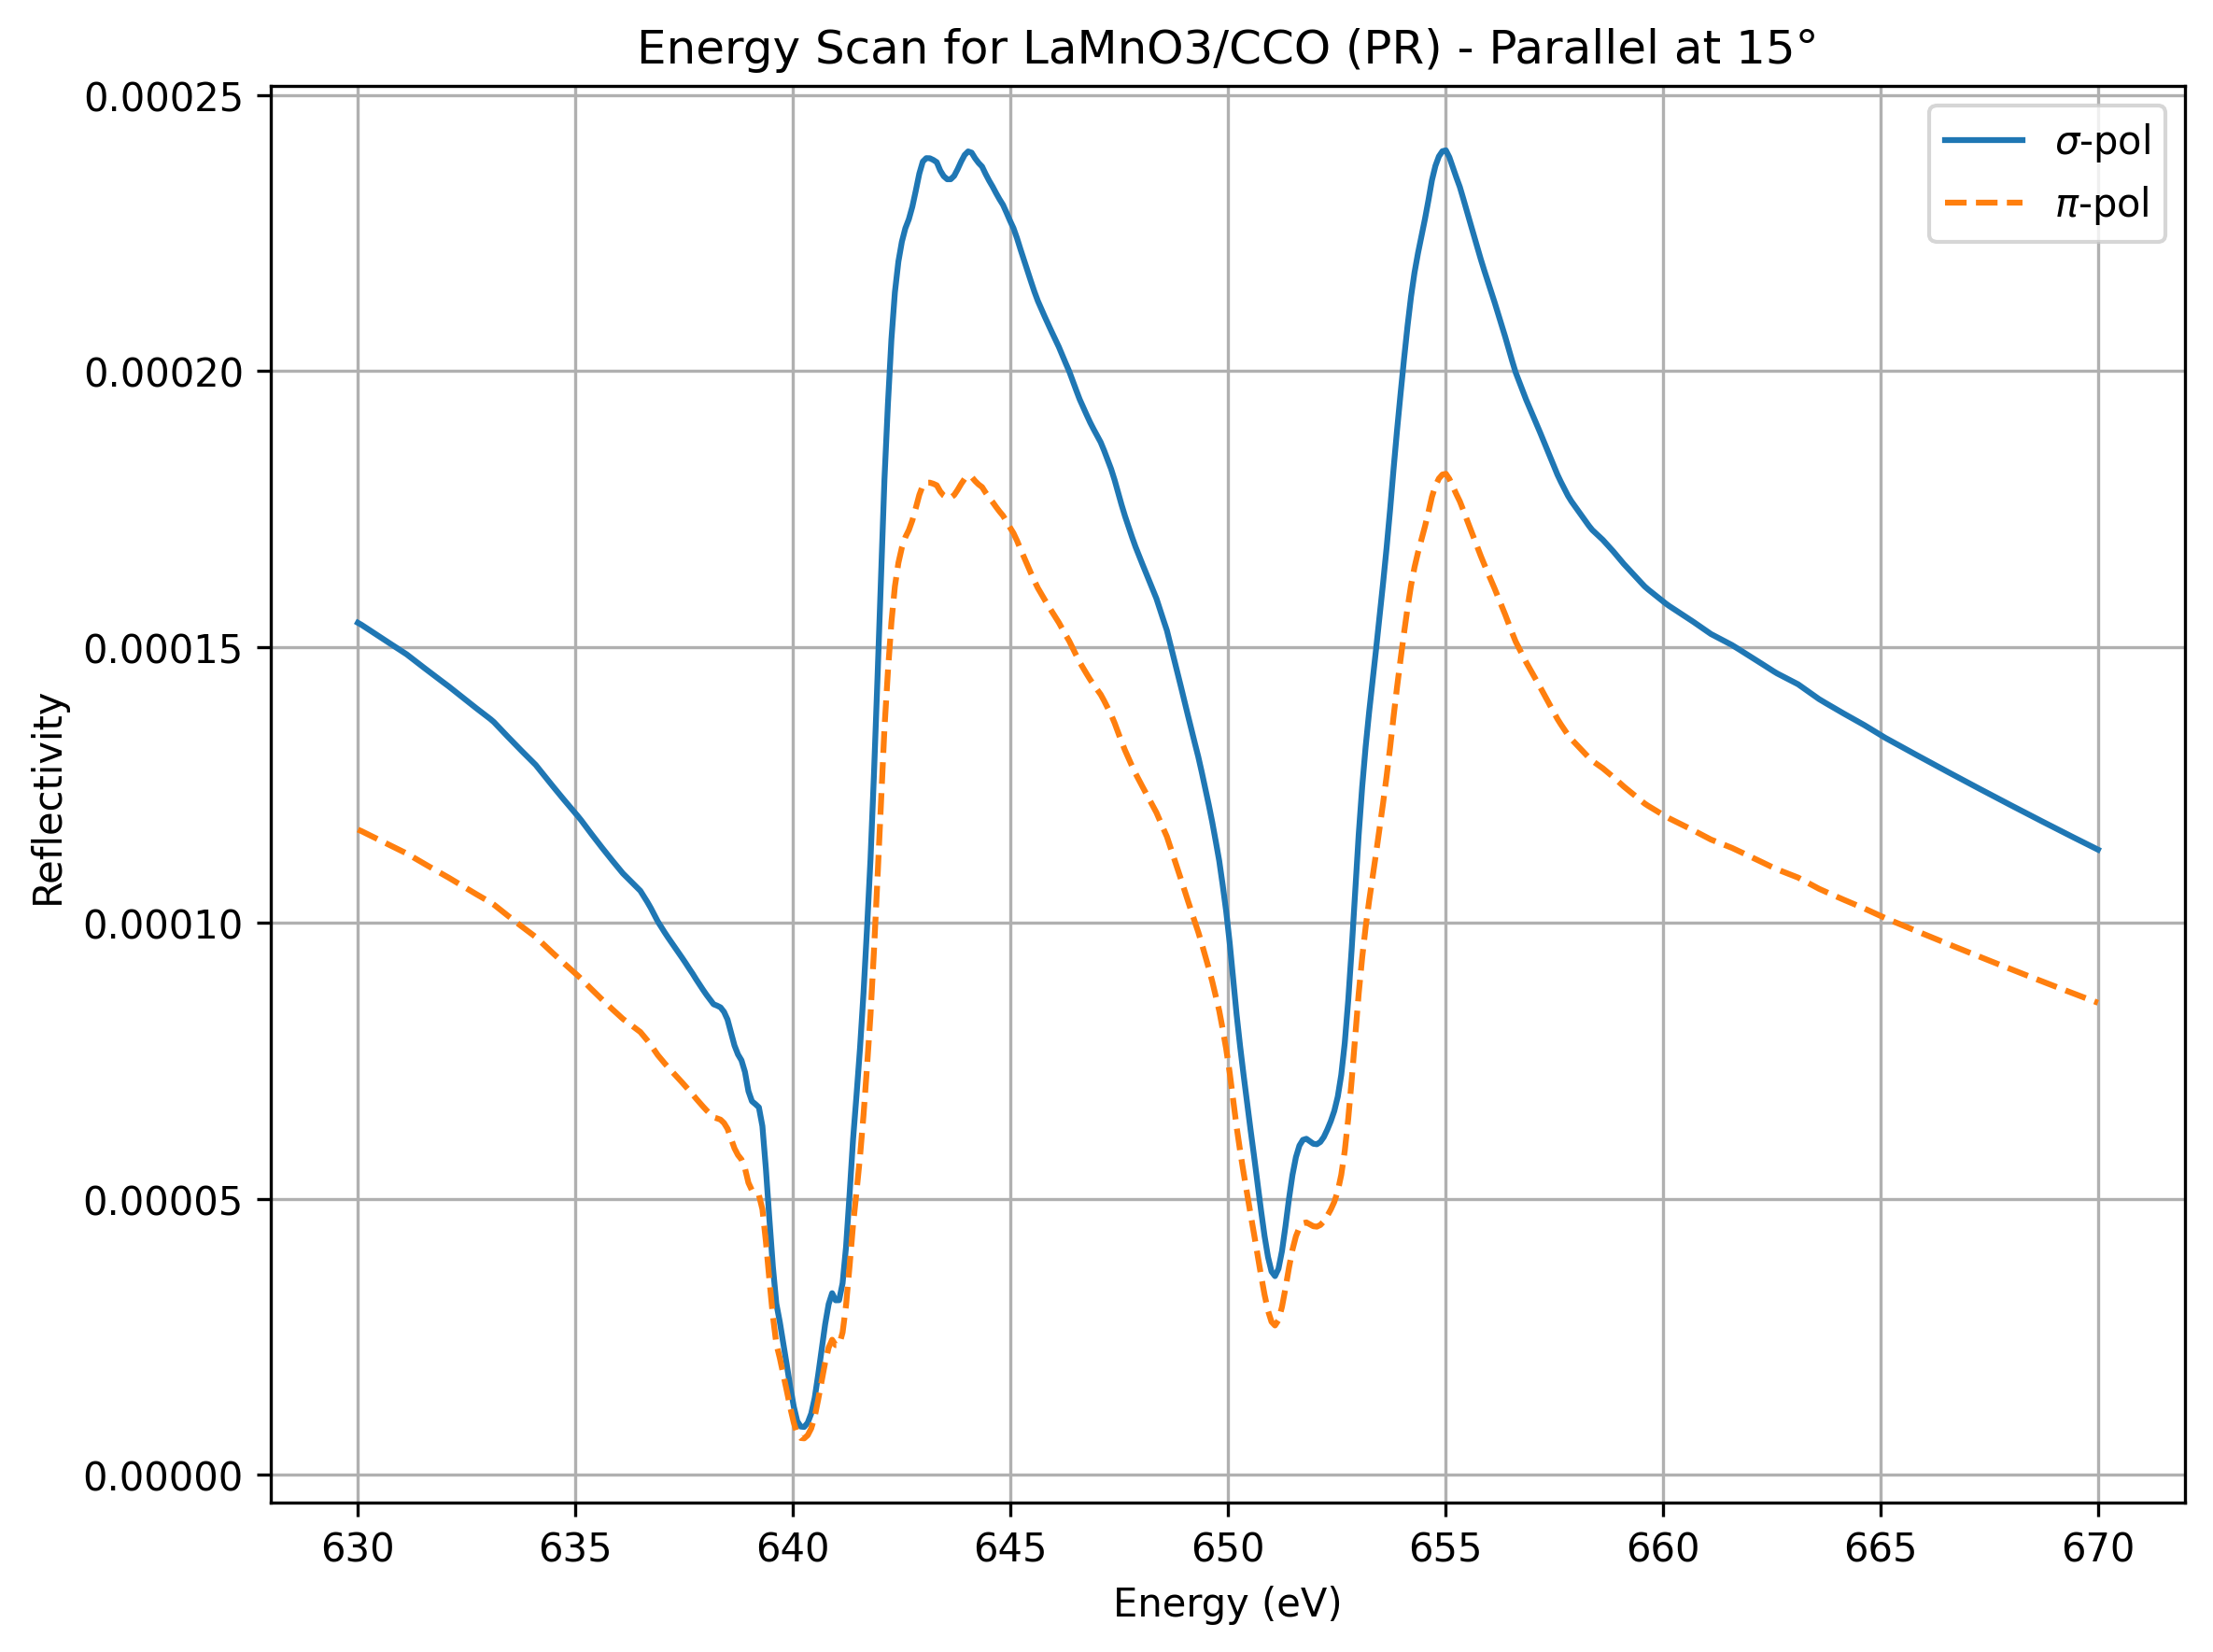

In [76]:
start_time = time.time()

e_evs = np.linspace(630, 670, num=500).tolist()
theta_deg = 15

e_pr, R_phi_pr, R_pi_pr  = energy_scan_parallel_pr(struc, e_evs, theta_deg, use_threads=True)

end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time:.3f} segundos")

plot_energy_scan(e_pr, R_phi_pr, R_pi_pr, theta_deg, "LaMnO3/CCO (PR) - Parallel")